<a href="https://colab.research.google.com/github/RomuloAlves2507/TrabalhoIA_unila_/blob/main/trabalhoIA_Unila.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trabalho de IA para Engenharia, tem como objetivo desenvolver e avaliar modelos de machine learning para diagnosticar a condição operacional de quatro componentes críticos (resfriador, válvula, bomba e acumulador) de um sistema hidráulico, utilizando dados brutos de múltiplos sensores.

Condition monitoring of hydraulic systems Data Set at ZeMA
     https://zenodo.org/records/1323611#.XfzEAEFCeUm

In [ ]:
#import das bibliotecas necessárias
import pandas as pd
import pyarrow
from google.colab import files
import io
import os
from IPython.display import clear_output
import time

from google.colab import drive
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

try:
    import shap
except ImportError:
    print("Instalando biblioteca SHAP")
    !pip install shap
    import shap

import numpy as np

In [ ]:
 #Criar arquivo parket a partir de 18 arquivos .txt (17 reais de sensores e 1 arquivo alvo)
def processar_arquivos_sensores(uploaded_files):
    print("Processando arquivos de SENSORES...")
    lista_de_dados_dos_arquivos = []
    numero_de_linhas_esperado = -1

    nomes_dos_arquivos = sorted(uploaded_files.keys())

    for filename in nomes_dos_arquivos:
        content = uploaded_files[filename].decode('utf-8')
        linhas = io.StringIO(content).readlines()

        if numero_de_linhas_esperado == -1:
            numero_de_linhas_esperado = len(linhas)
        elif len(linhas) != numero_de_linhas_esperado:
            print(f" ERRO: Arquivos de sensor com números de linhas diferentes!")
            print(f"Esperado: {numero_de_linhas_esperado}, Arquivo {filename} tem: {len(linhas)}")
            return None

    if numero_de_linhas_esperado == 0:
        print("Aviso: Os arquivos de sensores estão vazios.")
        return None

    print(f"Validação OK: Todos os {len(nomes_dos_arquivos)} arquivos de sensor têm {numero_de_linhas_esperado} linhas.")

    dados_combinados_finais = []

    for i in range(numero_de_linhas_esperado):
        linha_final_combinada = []
        for dados_arquivo_em_memoria in lista_de_dados_dos_arquivos:
            pass
        pass

    lista_de_dados_em_memoria = []
    for filename in nomes_dos_arquivos:
         content = uploaded_files[filename].decode('utf-8')
         linhas = io.StringIO(content).readlines()
         lista_de_dados_em_memoria.append(linhas)

    dados_combinados_finais = []
    for i in range(numero_de_linhas_esperado):
        linha_final_combinada = []
        for dados_arquivo in lista_de_dados_em_memoria:
            linha_atual = dados_arquivo[i].strip()
            valores_split = linha_atual.split()

            try:
                valores_float = []
                for val in valores_split:
                    val_corrigido = val.replace(',', '.')
                    valores_float.append(float(val_corrigido))
                linha_final_combinada.extend(valores_float)
            except ValueError as e:
                print(f" ERRO DE DADOS (Sensor) ")
                print(f"Linha: {i+1}, Valor: '{val}'")
                return None

        dados_combinados_finais.append(linha_final_combinada)

    print("Processamento de sensores concluído.")
    # Renomeia as colunas dos sensores para "f_0", "f_1", ... (feature_0, feature_1)
    df_sensores = pd.DataFrame(dados_combinados_finais)
    df_sensores.columns = [f'f_{i}' for i in range(len(df_sensores.columns))]

    return df_sensores, numero_de_linhas_esperado

def processar_arquivo_profile(uploaded_file, linhas_esperadas):
    print("Processando arquivo PROFILE...")

    if len(uploaded_file) != 1:
        print("ERRO: Por favor, selecione exatamente UM arquivo profile.txt")
        return None

    filename = list(uploaded_file.keys())[0]
    content = uploaded_file[filename].decode('utf-8')
    linhas = io.StringIO(content).readlines()

    if len(linhas) != linhas_esperadas:
        print(f"ERRO DE SINCRONIZAÇÃO")
        print(f"Os arquivos de sensor têm {linhas_esperadas} linhas, mas o profile.txt tem {len(linhas)} linhas.")
        return None

    print("Validação OK: O arquivo profile tem o mesmo número de linhas dos sensores.")

    dados_profile = []
    for i, linha_texto in enumerate(linhas):
        linha_atual = linha_texto.strip().split()

        # O profile.txt tem valores inteiros, não float
        try:
            # Converte para int
            valores_int = [int(float(v.replace(',', '.'))) for v in linha_atual]
            dados_profile.append(valores_int)
        except ValueError as e:
            print(f"ERRO DE DADOS (Profile)")
            print(f"Linha: {i+1}, Valor: '{linha_atual}'")
            return None

    # Nomes das colunas alvo
    colunas_alvo = ['resfriador', 'valvula', 'bomba', 'acumulador', 'stable_flag']

    df_profile = pd.DataFrame(dados_profile, columns=colunas_alvo[:len(dados_profile[0])])

    # Ajusta os nomes das colunas se o profile tiver menos de 5 colunas
    if len(df_profile.columns) < 5:
        df_profile.columns = colunas_alvo[:len(df_profile.columns)]

    print("Processamento do profile concluído.")
    return df_profile

def combinar_parquet():
    try:
        #Carregar Arquivos de Sensores (Features - X) ---
        print("ETAPA 1: SENSORES (FEATURES)")
        print("Por favor, selecione os 17 arquivos .txt dos SENSORES (PS1, TS1, CE, etc.)")
        uploaded_sensores = files.upload()
        if not uploaded_sensores:
            print("Nenhum arquivo de sensor selecionado. Operação cancelada.")
            return

        df_X, num_linhas = processar_arquivos_sensores(uploaded_sensores)
        if df_X is None:
            return

        #Carregar Arquivo de Alvo (Target - y)
        print("\n ETAPA 2: ALVO (TARGET)")
        print("Por favor, selecione o arquivo .txt de ALVO (profile.txt)")
        uploaded_profile = files.upload()
        if not uploaded_profile:
            print("Nenhum arquivo de alvo selecionado. Operação cancelada.")
            return

        df_y = processar_arquivo_profile(uploaded_profile, num_linhas)
        if df_y is None:
            return

        print("\n ETAPA 3: COMBINANDO DADOS")

        # Concatena os DataFrames lado a lado (axis=1)
        df_final_combinado = pd.concat([df_X, df_y], axis=1)

        print(f"Sucesso! Dados combinados.")
        print(f"Shape Final: {df_final_combinado.shape}")
        print("Primeiras 5 linhas e últimas 5 colunas (para conferir):")
        print(df_final_combinado.iloc[:5, -5:])

        #Salvar e Baixar o Parquet
        output_filename = 'dados_completos.parquet'
        print(f"\nSalvando arquivo Parquet como: {output_filename}")

        df_final_combinado.to_parquet(output_filename, engine='pyarrow', index=False)

        print(f"\n SUCESSO! :) ")
        print(f"Iniciando o download de '{output_filename}' para seu computador...")
        files.download(output_filename)

    except Exception as e:
        print(f"\n OCORREU UM ERRO ")
        print(f"Erro: {e}")


In [ ]:
# Configurações Globais
TARGET_COLUMNS = ['resfriador', 'valvula', 'bomba', 'acumulador']
FLAG_COLUMN = ['stable_flag']
X_global = None
y_global = None


def carregar_arquivo_parquet_drive():

    print("Conectando ao Google Drive...")
    # Isso vai pedir permissão para acessar seu Drive na primeira vez
    drive.mount('/content/drive')

    #Caso queira que digite o caminho sempre:
    #print("\n--- SELEÇÃO DE ARQUIVO DO DRIVE ---")
    #print("Digite o caminho do arquivo no seu Drive.")
    #print("Exemplo: /content/drive/MyDrive/Pasta_do_Projeto/dados_completos.parquet")
    #print("Dica: Você pode copiar o caminho clicando com botão direito no arquivo na aba de arquivos à esquerda.")

    #caminho_arquivo = "input("Caminho do arquivo: ").strip()"

    # Remove aspas
    #caminho_arquivo = caminho_arquivo.replace('"', '').replace("'", "")


    #como sei o caminho e não
    caminho_arquivo = "/content/drive/MyDrive/Unila/Ia//Data/dados_completos.parquet"



    if not os.path.exists(caminho_arquivo):
        print(f"ERRO: Arquivo não encontrado no caminho: {caminho_arquivo}")
        print("Verifique se o nome está correto e se o Drive foi montado.")
        return None

    try:
        print(f"Carregando '{caminho_arquivo}'...")
        df = pd.read_parquet(caminho_arquivo)
        print("Arquivo Parquet carregado com sucesso!")
        return df
    except Exception as e:
        print(f"Erro ao ler o arquivo Parquet: {e}")
        return None

def carregar_arquivo_parquet():
    print("Abrindo seletor de arquivos... Por favor, selecione seu arquivo .parquet")
    uploaded = files.upload()

    if not uploaded:
        print("Nenhum arquivo selecionado. Operação cancelada.")
        return None

    if len(uploaded) > 1:
        print("Por favor, selecione apenas UM arquivo. Operação cancelada.")
        return None

    filename = list(uploaded.keys())[0]
    print(f"Carregando '{filename}'...")

    try:
        df = pd.read_parquet(io.BytesIO(uploaded[filename]))
        print("Arquivo Parquet carregado com sucesso.")
        return df
    except Exception as e:
        print(f"Erro ao ler o arquivo Parquet: {e}")
        return None

def separar_features_e_alvos(df_completo):
    # Separa o DataFrame em X (features) e y (alvos)
    if df_completo is None:
        print("DataFrame de entrada está Vazio. Não é possível separar os dados.")
        return None, None

    print("Separando features (X) e alvos (y)...")

    try:
        y_targets = df_completo[TARGET_COLUMNS]
        colunas_para_remover_de_X = TARGET_COLUMNS + FLAG_COLUMN
        X_features = df_completo.drop(columns=colunas_para_remover_de_X)

        print(f" Shape das Features (X): {X_features.shape}")
        print(f" Shape dos Alvos (y):     {y_targets.shape}")

        return X_features, y_targets

    except KeyError as e:
        print(f" ERRO: Coluna não encontrada!")
        print(f"Verifique as constantes 'TARGET_COLUMNS' e 'FLAG_COLUMN'.")
        print(f"Colunas encontradas: {list(df_completo.columns)}")
        return None, None
    except Exception as e:
         print(f"Erro inesperado ao separar features e alvos: {e}")
         return None, None


In [ ]:
def plotar_importancia_features(modelo, X_train, target_name, top_n=20):
  print(f"\nGerando Gráficos de Importância para: {target_name.upper()}...")

  # 1. Extrair e Organizar Importâncias
  importancias = modelo.feature_importances_
  # Cria um DataFrame para facilitar a manipulação
  df_imp = pd.DataFrame({
      'feature': X_train.columns,
      'importance': importancias
  })

  # Ordena do maior para o menor
  df_imp = df_imp.sort_values(by='importance', ascending=False)

  # 2. Separar Top e Bottom
  df_top = df_imp.head(top_n)
  df_bottom = df_imp.tail(top_n)

  # --- GRÁFICO 1: AS MAIS IMPORTANTES (TOP) ---
  plt.figure(figsize=(12, 8))
  sns.barplot(x='importance', y='feature', data=df_top, palette="viridis")
  plt.title(f'Top {top_n} Features MAIS Importantes - {target_name} (O que monitorar)', fontsize=14)
  plt.xlabel('Importância (Gini)', fontsize=12)
  plt.ylabel('Sensor', fontsize=12)
  plt.tight_layout()
  plt.show()

  # --- GRÁFICO 2: AS MENOS IMPORTANTES (BOTTOM) ---
  plt.figure(figsize=(12, 8))
  sns.barplot(x='importance', y='feature', data=df_bottom, palette="Reds_r")
  plt.title(f'Top {top_n} Features MENOS Importantes - {target_name} (Candidatas a descarte)', fontsize=14)
  plt.xlabel('Importância (Gini) - Note a escala muito baixa', fontsize=12)
  plt.ylabel('Sensor', fontsize=12)
  plt.tight_layout()
  plt.show()

In [ ]:
def randomForest(X, y, quant_arvores):

  print("\n" + "="*60)
  print(f"--- TREINAMENTO: RANDOM FOREST COM {quant_arvores} ÁRVORES---")
  print("="*60)

  # Dicionários para guardar dados para análise shap
  modelos_treinados = {}
  dados_treino = {}
  dados_teste = {}
  ultimo_target = ""

  for target_name in y.columns:
    print(f"\n>>> ANALISANDO ALVO: {target_name.upper()}")
    y_target = y[target_name].astype(str)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_target, test_size=0.3, random_state=42, stratify=y_target
    )
    # Treina (usando 100 árvores para um modelo robusto)
    clf = RandomForestClassifier(n_estimators=quant_arvores, n_jobs=-1, random_state=42)
    clf.fit(X_train, y_train)

    # Métricas Básicas
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Acurácia: {acc*100:.2f}%")

    # Matriz de Confusão (pequena, só para conferência)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title(f'Matriz Confusão: {target_name}')
    plt.show()

    modelos_treinados[target_name] = clf
    dados_treino[target_name] = X_train
    dados_teste[target_name] = X_test
    ultimo_target = target_name

    if ultimo_target:
      print("\n" + "#"*80)
      print(f" GERANDO ANÁLISE GRÁFICA DETALHADA PARA: {ultimo_target.upper()} ".center(80, '#'))
      print("#"*80)

      modelo_final = modelos_treinados[ultimo_target]
      X_train_final = dados_treino[ultimo_target]
      X_test_final = dados_teste[ultimo_target]

      plotar_importancia_features(modelo_final, X_train_final, ultimo_target, top_n=20)

    print("\n--- Análise Gráfica Concluída ---")




In [ ]:
def arvore_decisao(X, y, crit, lim_prof,min_folhas):
  print("\n" + "="*60)
  print(f"--- TREINAMENTO: ÁRVORE DE DECISÃO (Decision Tree)---")
  print(f'Critério {crit} - Profundidade Lim: {lim_prof} - Nº min amostra / folha: {min_folhas}')
  print("="*60)

  for target_name in y.columns:
    print(f"\nANALISANDO: {target_name.upper()}")
    y_target = y[target_name].astype(str)

    # Divisão dos dados
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_target, test_size=0.3, random_state=42, stratify=y_target
    )

    # Cria e Treina o Modelo

    clf = DecisionTreeClassifier(
        random_state=42,
        criterion= crit,
        max_depth=lim_prof,            # Limita a profundidade
        min_samples_leaf= min_folhas      # Exige no mínimo min_folhas amostras por folha
    )

    clf.fit(X_train, y_train)

    # Previsão
    y_pred = clf.predict(X_test)
    # Cálculo da Acurácia
    acc = accuracy_score(y_test, y_pred)
    print(f"Acurácia: {acc*100:.2f}%")

    # --- GERAÇÃO DO GRÁFICO (Matriz de Confusão) ---
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
    plt.title(f'Matriz de Confusão: {target_name}')
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.show()


In [ ]:
def regressao_logistica(X, y, p, c, s, m):

  print("\n" + "="*60)
  print("--- TREINAMENTO: REGRESSÃO LOGÍSTICA ---")
  print(f'Penalty {p} - Força da Regularização (C): {c} - Solver: {s} - Max_Iter: {m}')
  print("="*60)

  for target_name in y.columns:
    print(f"\nANALISANDO: {target_name.upper()}")
    y_target = y[target_name].astype(str)

    # Divisão Treino/Teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_target, test_size=0.3, random_state=42, stratify=y_target
    )

    # Cria Pipeline: Padronização -> Modelo Linear
    clf = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            penalty=p,
            C=c,
            solver= s,
            max_iter=m,
            random_state=42
        )
    )

    clf.fit(X_train, y_train)

    # Previsão
    y_pred = clf.predict(X_test)

    # Acurácia
    acc = accuracy_score(y_test, y_pred)
    print(f"Acurácia: {acc*100:.2f}%")

    # --- GERAÇÃO DO GRÁFICO (Matriz de Confusão) ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
    plt.title(f'Matriz de Confusão (Reg. Logística): {target_name}')
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.show()




In [ ]:
def gradient_boosting(X, y, ne, lr,md):
  print("\n" + "="*60)
  print("--- TREINAMENTO: GRADIENT BOOSTING ---")
  print("="*60)

  for target_name in y.columns:
    print(f"\nANALISANDO: {target_name.upper()}")
    y_target = y[target_name].astype(str)

    # Divisão Treino/Teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_target, test_size=0.3, random_state=42, stratify=y_target
    )

    # Cria e Treina o Modelo
    clf = GradientBoostingClassifier(
      n_estimators=ne,
      learning_rate=lr,
      max_depth=md,
      random_state=42
    )

    clf.fit(X_train, y_train)

    # Previsão
    y_pred = clf.predict(X_test)

    # Acurácia
    acc = accuracy_score(y_test, y_pred)
    print(f"Acurácia: {acc*100:.2f}%")

    # --- GERAÇÃO DO GRÁFICO (Matriz de Confusão) ---
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
    plt.title(f'Matriz de Confusão (Grad. Boosting): {target_name}')
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.show()





In [ ]:
def lda(X, y, solver_type, shrinkage_val):

  print("\n" + "="*60)
  print("--- TREINAMENTO: LDA (Linear Discriminant Analysis) ---")
  print(f"Solver: {solver_type} | Shrinkage: {shrinkage_val}")
  print("="*60)

  for target_name in y.columns:
    print(f"\nANALISANDO: {target_name.upper()}")
    y_target = y[target_name].astype(str)

    # Divisão Treino/Teste
    X_train, X_test, y_train, y_test = train_test_split(
      X, y_target, test_size=0.3, random_state=42, stratify=y_target
    )

    # Cria Pipeline: Padronização -> LDA com parâmetros
    # O StandardScaler continua sendo vital para o LDA
    clf = make_pipeline(
      StandardScaler(),
      LinearDiscriminantAnalysis(solver=solver_type, shrinkage=shrinkage_val)
    )

    try:
      clf.fit(X_train, y_train)

      # Previsão
      y_pred = clf.predict(X_test)

      # Acurácia
      acc = accuracy_score(y_test, y_pred)
      print(f"Acurácia: {acc*100:.2f}%")

    except Exception as e:
      print(f"Erro no treinamento: {e}")
      print("Dica: O solver 'svd' não aceita shrinkage.")

    # --- GERAÇÃO DO GRÁFICO (Matriz de Confusão) ---
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    # Usei 'Blues' para diferenciar
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão (LDA): {target_name}')
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.show()

In [ ]:
def svm(X, y, kernel_type, c_value):

  print("\n" + "="*60)
  print("--- TREINAMENTO: SVM (Support Vector Machine) ---")
  print(f"Kernel: {kernel_type} | C: {c_value}")
  print("="*60)

  for target_name in y.columns:
    print(f"\nANALISANDO: {target_name.upper()}")
    y_target = y[target_name].astype(str)

    # Divisão Treino/Teste
    X_train, X_test, y_train, y_test = train_test_split(
      X, y_target, test_size=0.3, random_state=42, stratify=y_target
    )

    # O cache_size=1000 ajuda a usar mais RAM para acelerar o processo
    clf = make_pipeline(
      StandardScaler(),
      SVC(kernel=kernel_type, C=c_value, cache_size=1000, random_state=42)
    )

    clf.fit(X_train, y_train)

    # Previsão
    y_pred = clf.predict(X_test)

    # Acurácia
    acc = accuracy_score(y_test, y_pred)
    print(f"Acurácia: {acc*100:.2f}%")

    # --- GERAÇÃO DO GRÁFICO (Matriz de Confusão) ---
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão (SVM): {target_name}')
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.show()


--- Análise de Dados Hidráulicos ---
O que você gostaria de fazer?
  [1] Criar um novo arquivo 'dados_completos.parquet' a partir dos arquivos .txt
  [2] Carregar um arquivo .parquet existente para treinar
  [3] Iniciar Treinamento
  [4] DRIVE: Carregar um arquivo .parquet existente através do DRIVE
  [Digite 'sair' para fechar]
Escolha uma opção: 3
ESCOLHA UM ALGORÍTMO DE TREINAMENTO
  [1] Random Forest
  [2] Árvore de Decisão
  [3] Regressão Logística
  [4] Gradient Boosting
  [5] LDA
  [6] SVM
  [7] TODOS
  [Digite '0' para voltar]
Escolha um algoritmo: 7

--- TREINAMENTO: RANDOM FOREST COM 100 ÁRVORES---

>>> ANALISANDO ALVO: RESFRIADOR
Acurácia: 99.85%


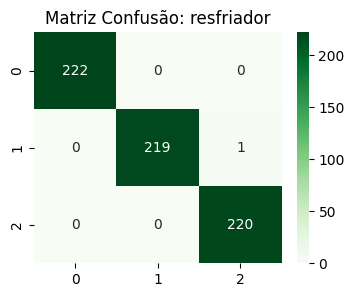


################################################################################
############## GERANDO ANÁLISE GRÁFICA DETALHADA PARA: RESFRIADOR ##############
################################################################################

Gerando Gráficos de Importância para: RESFRIADOR...


/tmp/ipython-input-1927779142.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=df_top, palette="viridis")


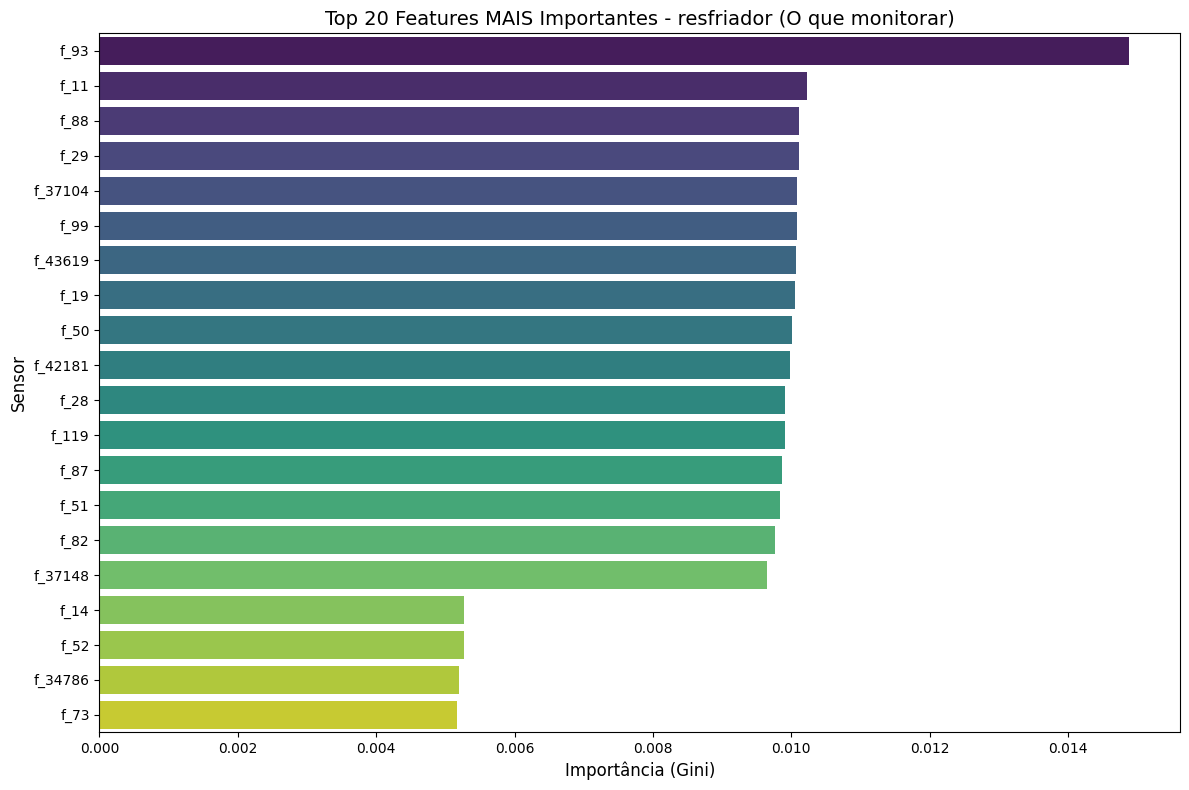

/tmp/ipython-input-1927779142.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=df_bottom, palette="Reds_r")


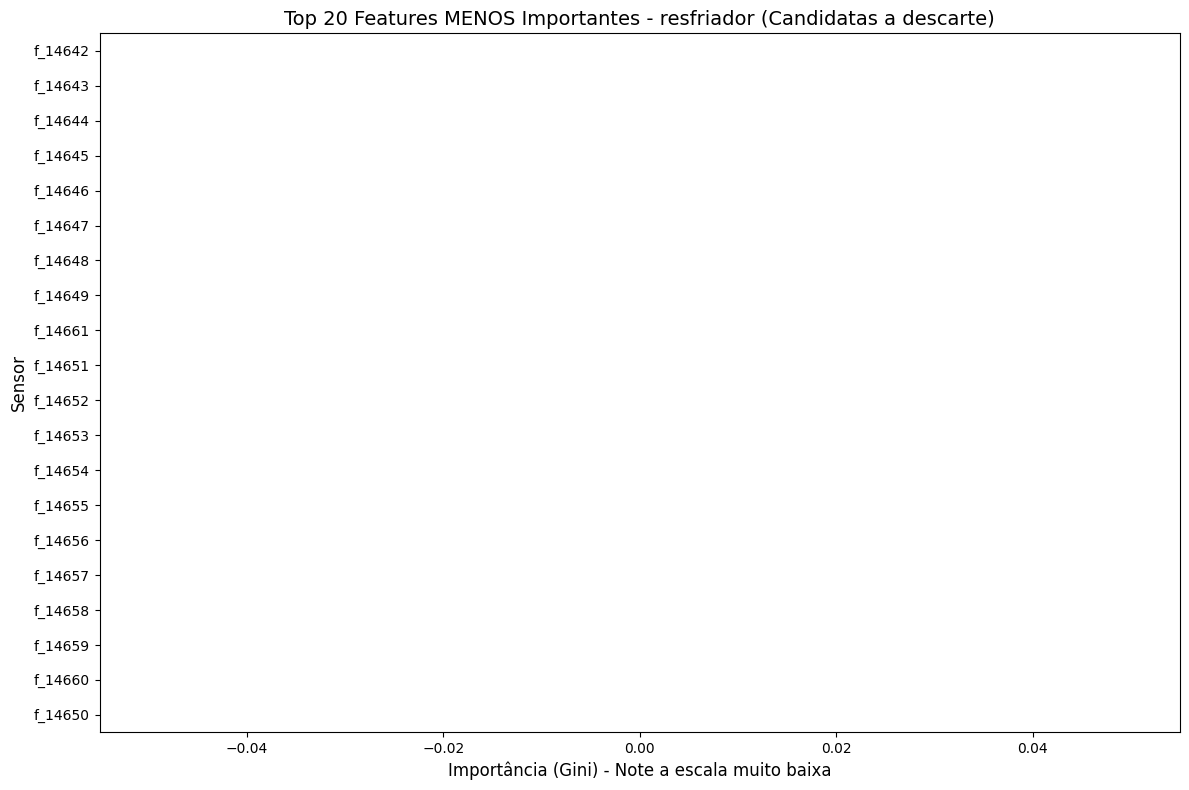


--- Análise Gráfica Concluída ---

>>> ANALISANDO ALVO: VALVULA
Acurácia: 100.00%


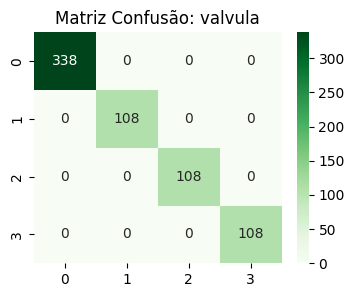


################################################################################
############### GERANDO ANÁLISE GRÁFICA DETALHADA PARA: VALVULA ################
################################################################################

Gerando Gráficos de Importância para: VALVULA...


/tmp/ipython-input-1927779142.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=df_top, palette="viridis")


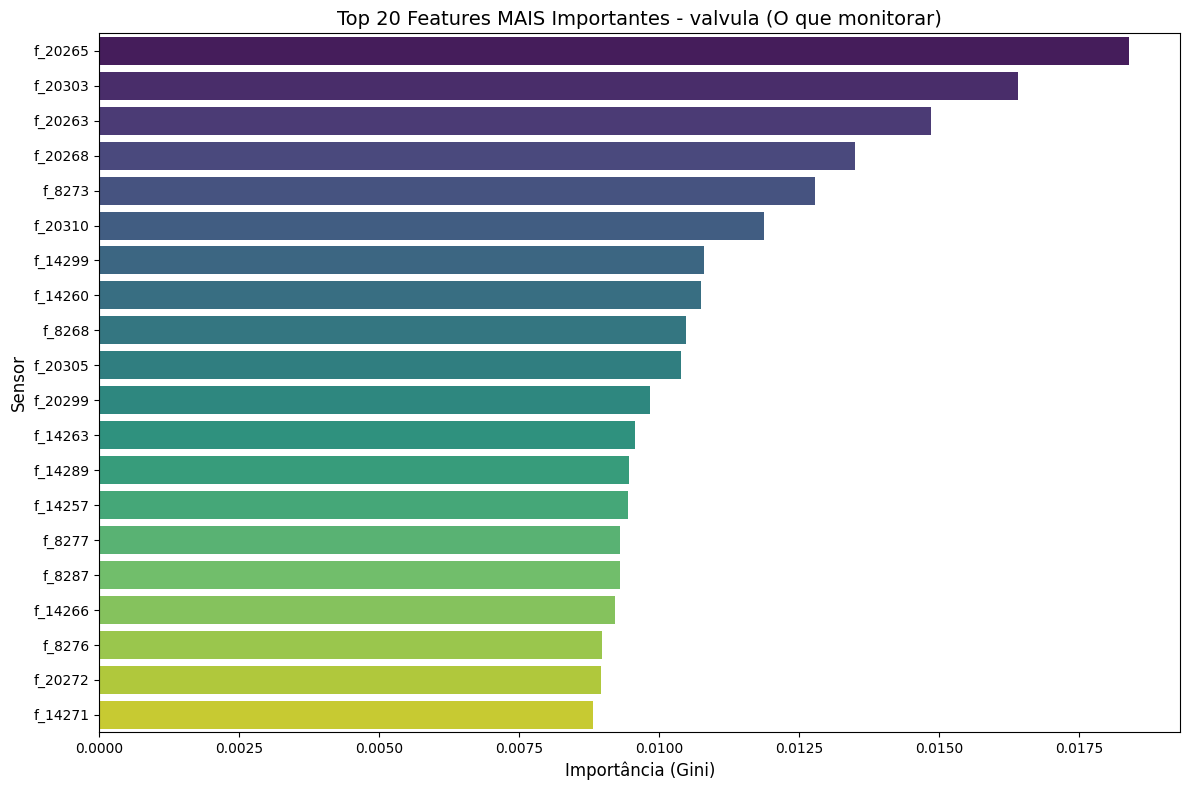

/tmp/ipython-input-1927779142.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=df_bottom, palette="Reds_r")


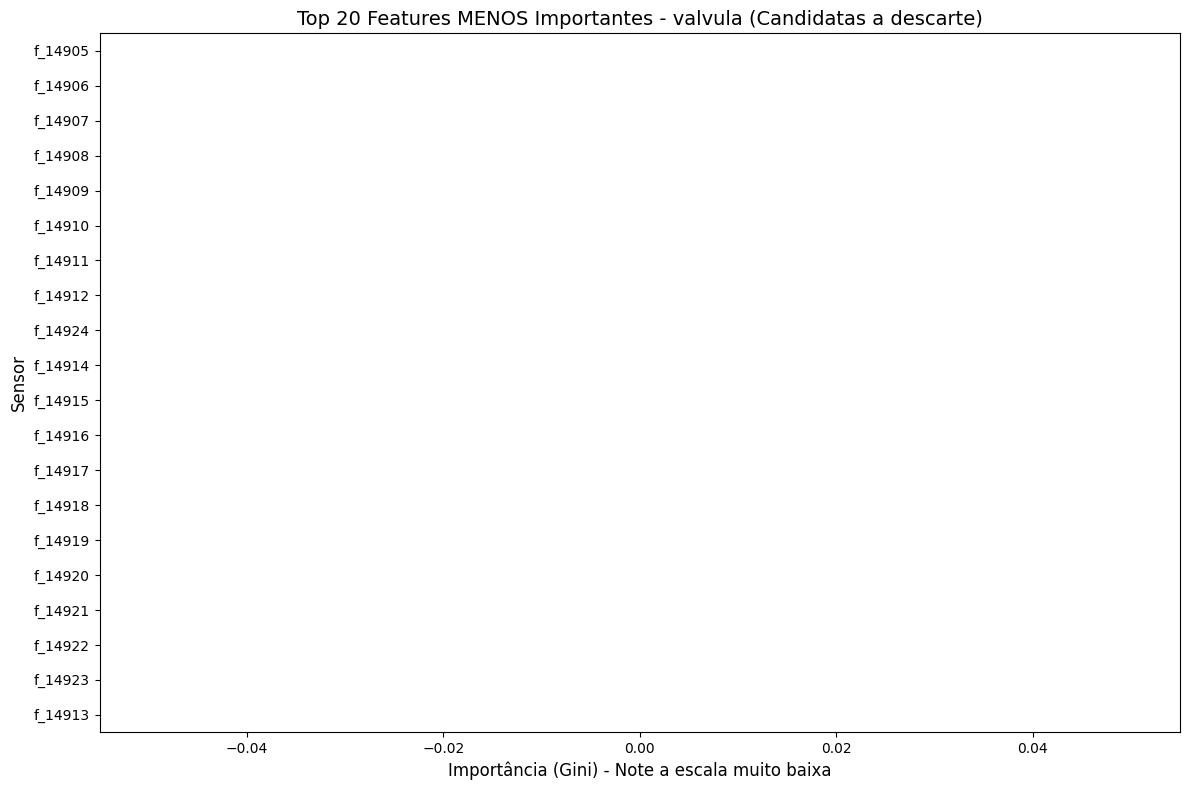


--- Análise Gráfica Concluída ---

>>> ANALISANDO ALVO: BOMBA
Acurácia: 99.55%


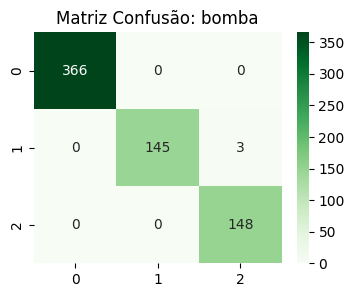


################################################################################
################ GERANDO ANÁLISE GRÁFICA DETALHADA PARA: BOMBA #################
################################################################################

Gerando Gráficos de Importância para: BOMBA...


/tmp/ipython-input-1927779142.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=df_top, palette="viridis")


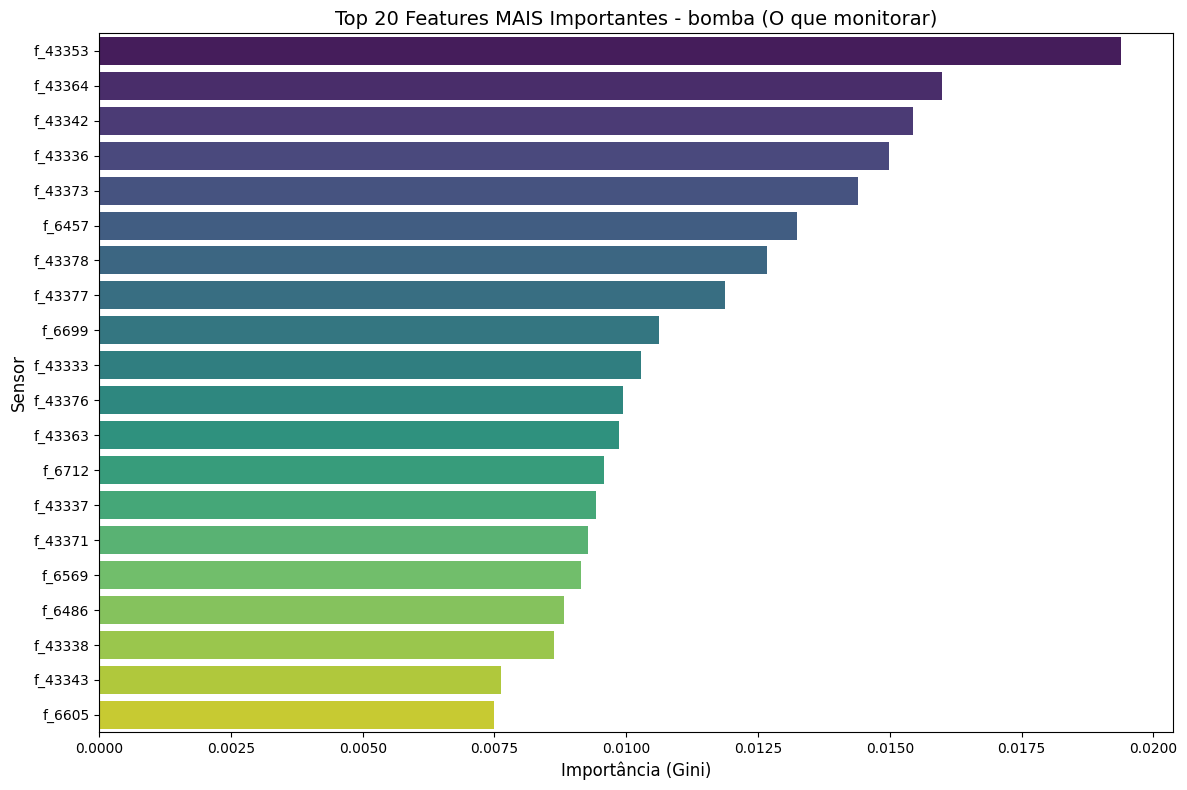

/tmp/ipython-input-1927779142.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=df_bottom, palette="Reds_r")


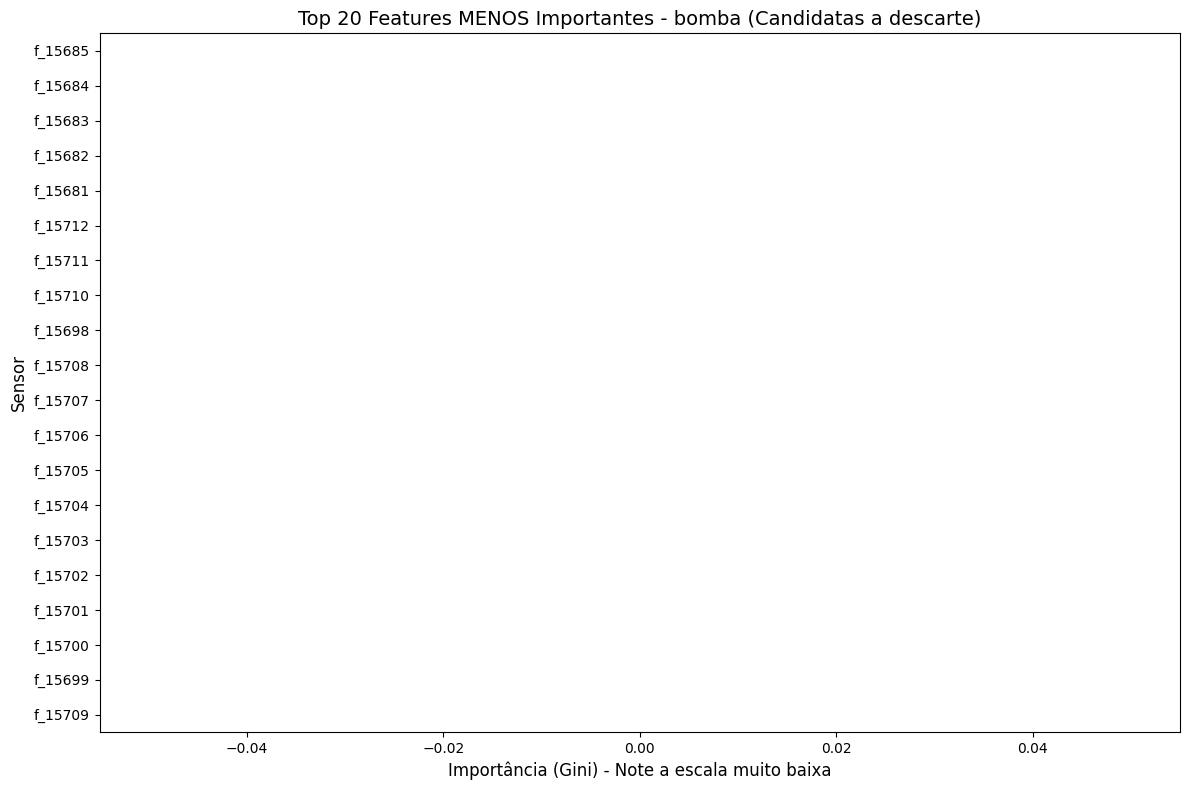


--- Análise Gráfica Concluída ---

>>> ANALISANDO ALVO: ACUMULADOR
Acurácia: 98.19%


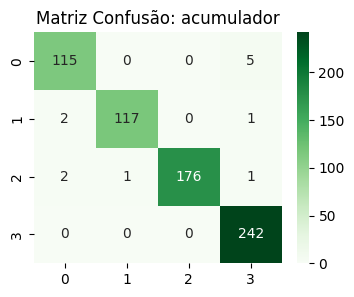


################################################################################
############## GERANDO ANÁLISE GRÁFICA DETALHADA PARA: ACUMULADOR ##############
################################################################################

Gerando Gráficos de Importância para: ACUMULADOR...


/tmp/ipython-input-1927779142.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=df_top, palette="viridis")


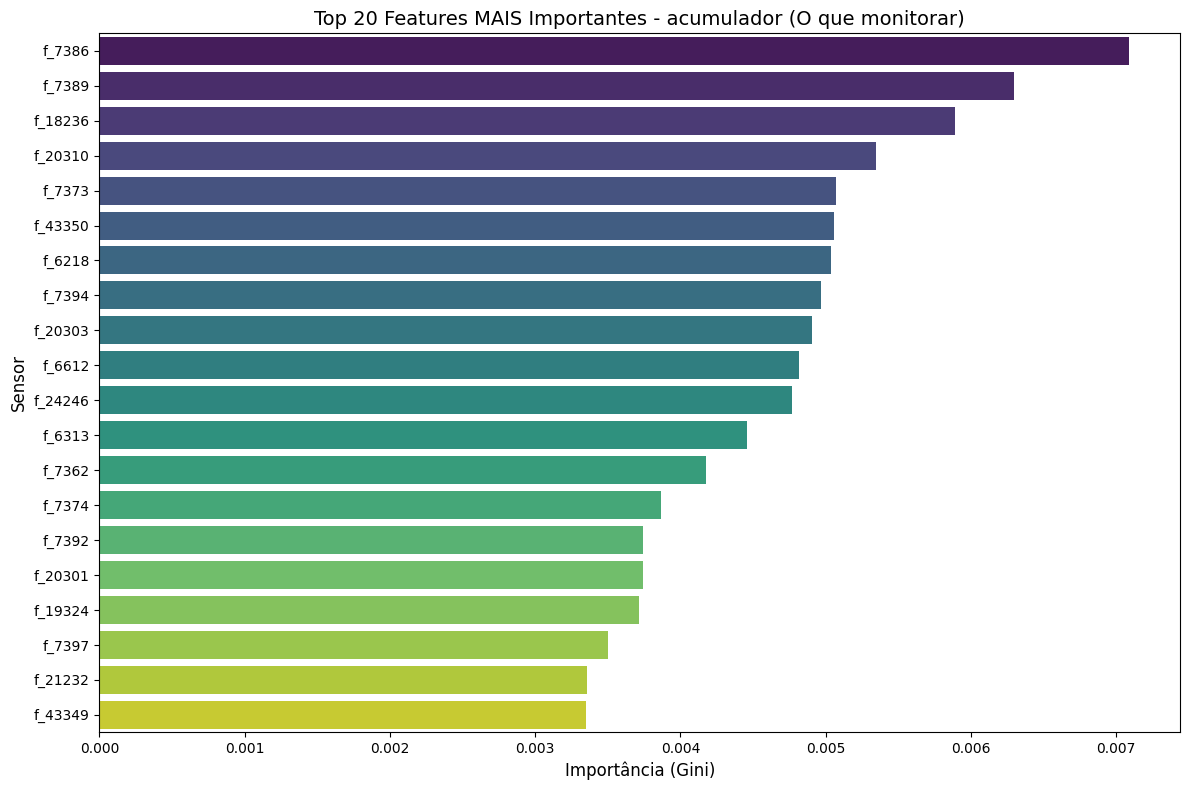

/tmp/ipython-input-1927779142.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=df_bottom, palette="Reds_r")


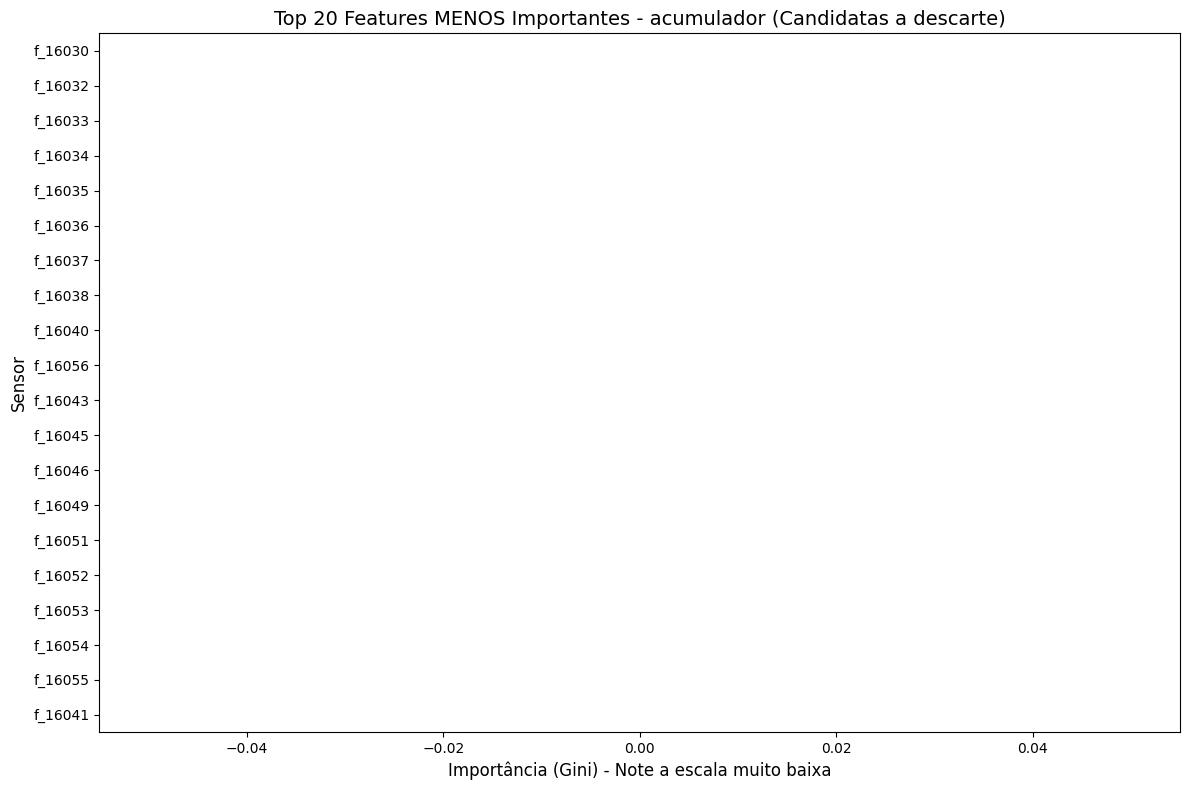


--- Análise Gráfica Concluída ---

--- TREINAMENTO: ÁRVORE DE DECISÃO (Decision Tree)---
Critério entropy - Profundidade Lim: 10 - Nº min amostra / folha: 10

ANALISANDO: RESFRIADOR
Acurácia: 100.00%


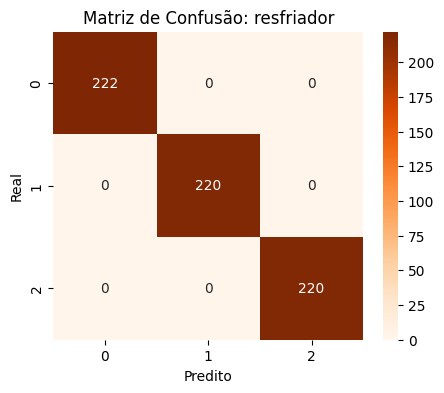


ANALISANDO: VALVULA
Acurácia: 100.00%


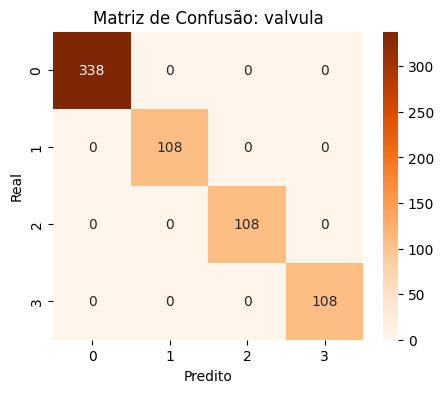


ANALISANDO: BOMBA
Acurácia: 98.04%


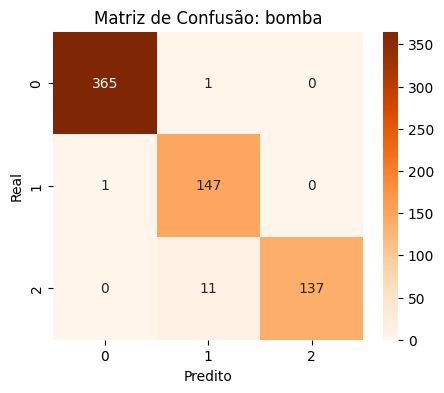


ANALISANDO: ACUMULADOR
Acurácia: 90.79%


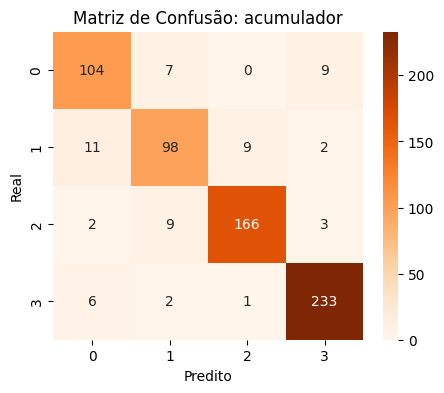


--- TREINAMENTO: REGRESSÃO LOGÍSTICA ---
Penalty l2 - Força da Regularização (C): 1.0 - Solver: lbfgs - Max_Iter: 1000

ANALISANDO: RESFRIADOR
Acurácia: 99.70%


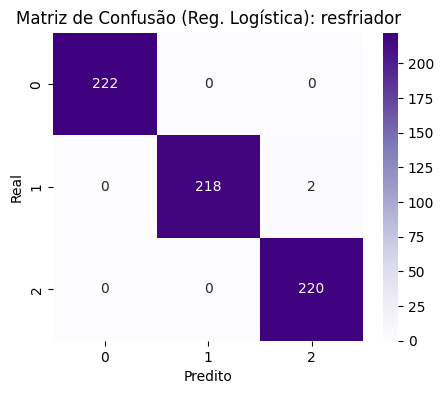


ANALISANDO: VALVULA
Acurácia: 99.85%


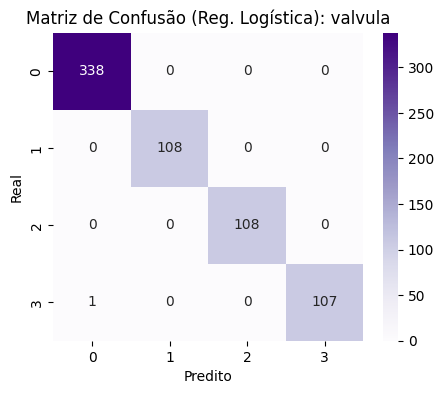


ANALISANDO: BOMBA
Acurácia: 97.58%


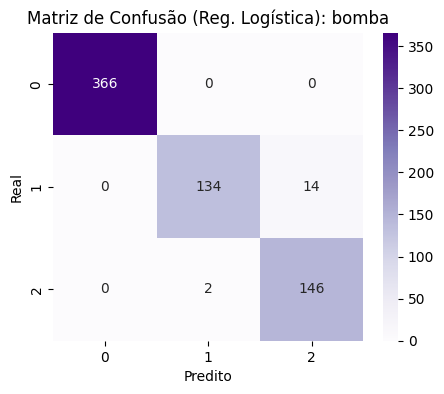


ANALISANDO: ACUMULADOR
Acurácia: 96.22%


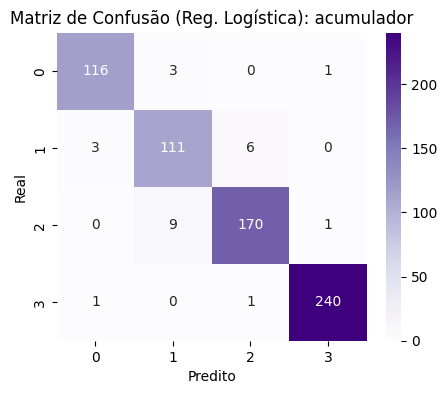


--- TREINAMENTO: LDA (Linear Discriminant Analysis) ---
Solver: svd | Shrinkage: None

ANALISANDO: RESFRIADOR
Acurácia: 99.85%


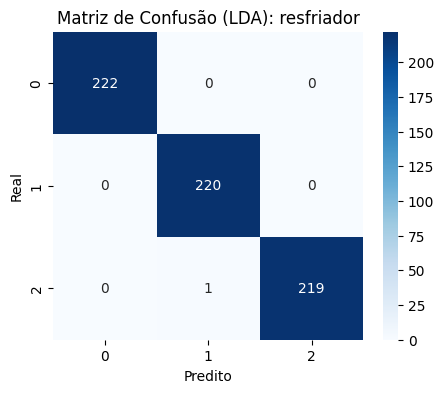


ANALISANDO: VALVULA
Acurácia: 100.00%


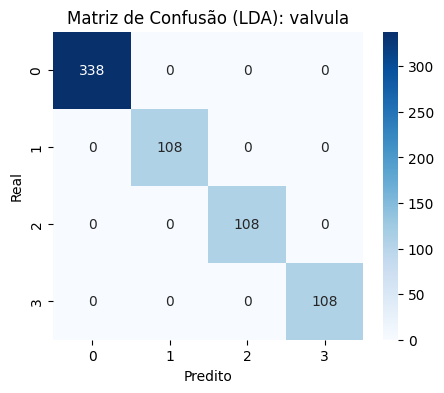


ANALISANDO: BOMBA
Acurácia: 99.85%


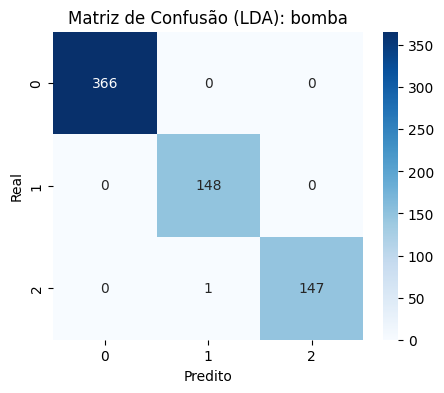


ANALISANDO: ACUMULADOR
Acurácia: 94.41%


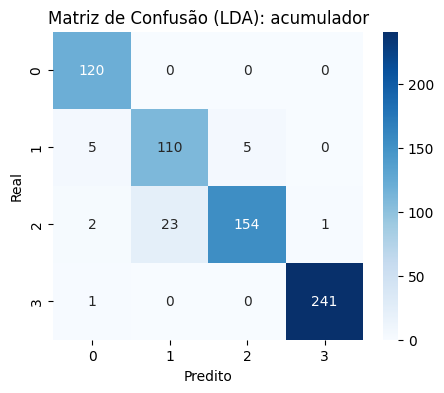


--- TREINAMENTO: SVM (Support Vector Machine) ---
Kernel: linear | C: 1.0

ANALISANDO: RESFRIADOR
Acurácia: 99.70%


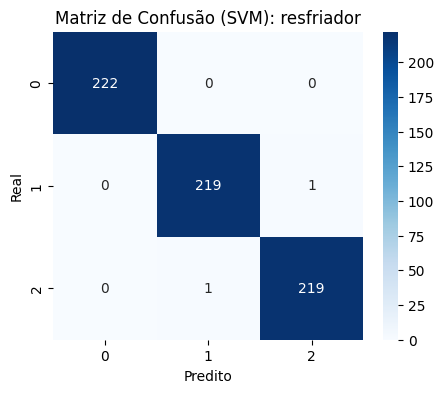


ANALISANDO: VALVULA
Acurácia: 100.00%


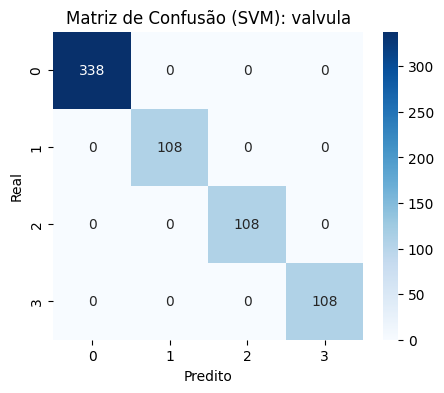


ANALISANDO: BOMBA
Acurácia: 100.00%


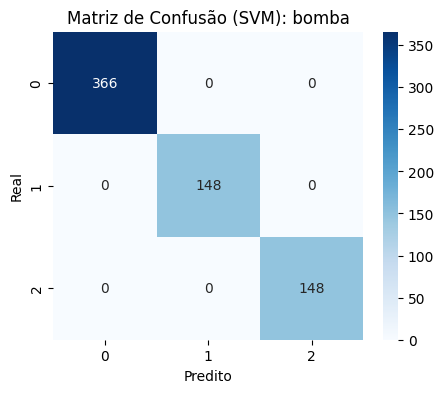


ANALISANDO: ACUMULADOR
Acurácia: 97.28%


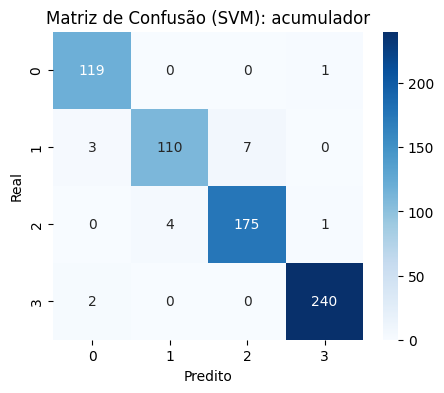

In [ ]:
from numpy import gradient
if __name__ == "__main__":

    while(True):

        clear_output(wait=True)

        print("--- Análise de Dados Hidráulicos ---")
        print("O que você gostaria de fazer?")
        print("  [1] Criar um novo arquivo 'dados_completos.parquet' a partir dos arquivos .txt")
        print("  [2] Carregar um arquivo .parquet existente para treinar")
        print("  [3] Iniciar Treinamento")
        print("  [4] DRIVE: Carregar um arquivo .parquet existente através do DRIVE")
        print("  [Digite 'sair' para fechar]")

        #resolver o problema de sincronização de buffer adicionei para dormir um pouco
        time.sleep(0.5)
        escolha = input("Escolha uma opção: ")

        if escolha == '1':
            print("\nIniciando Módulo de Criação de Parquet...")
            combinar_parquet()
            input("\nProcesso concluído.")

        elif escolha == '2':
            print("\nIniciando Carregamento do Arquivo...")
            # 1. Carrega o arquivo Parquet
            df_principal = carregar_arquivo_parquet()

            if df_principal is not None:
                # 2. Separa os dados
                X_global, y_global = separar_features_e_alvos(df_principal)

                if X_global is not None and y_global is not None:
                    print("\n--- Dados prontos para o treinamento ---")
                    pass
                else:
                    print("Falha ao separar features e alvos.")
            else:
                print("Falha ao carregar o arquivo Parquet.")

            time.sleep(4)

        elif escolha == '3':

            if X_global is None or y_global is None:
                print("Nenhum conjunto de dados carregado.")

            else:

              print("ESCOLHA UM ALGORÍTMO DE TREINAMENTO")
              print("  [1] Random Forest")
              print("  [2] Árvore de Decisão")
              print("  [3] Regressão Logística")
              print("  [4] Gradient Boosting")
              print("  [5] LDA")
              print("  [6] SVM")
              print("  [7] TODOS")
              print("  [Digite '0' para voltar]")
              time.sleep(0.5)
              algoritmo = input("Escolha um algoritmo: ")

              if algoritmo == '1':

                clear_output(wait=True)
                print("ESCOLHA UMA OPÇÂO:")
                print("  [1] Random Forest com 100 ÁRVORES")
                print("  [2] Digitar Número de Árvores")

                escolha = input("Digite uma opção: ")

                if escolha == '1':
                  quant_arvores = 100
                elif escolha == '2':
                  time.sleep(0.5)
                  quant_arvores = int(input("Digite o número de árvores: "))

                print("\nIniciando Treinamento Random Forest...")
                randomForest(X_global, y_global,quant_arvores)

              elif algoritmo == '2':

                clear_output(wait=True)
                print("ESCOLHA UMA OPÇÂO:")
                print("  [1] Treinar com Parâmetros pré-definidos")
                print("  [2] Digitar Parâmetros")
                escolha = input("Digite uma opção: ")

                if escolha == '1':
                  crit = 'entropy'
                  lim_prof = 10
                  min_folhas = 10
                elif escolha == '2':
                  print('Critério: ')
                  print('  [1] Gini')
                  print('  [2] Entropia')
                  time.sleep(0.5)
                  crit = input("Digite o NÚMERO do critério: ")
                  if crit == '1':
                    crit = 'gini'
                  elif crit == '2':
                    crit = 'entropy'
                  else:
                    print("Critério inválido. Adicionado Entropia como Padrão")
                    crit= 'entropy'

                  time.sleep(0.5)
                  lim_prof = int(input("Digite a profundidade máxima: "))
                  min_folhas = int(input("Digite o número mínimo de amostras por folha: "))

                arvore_decisao(X_global, y_global, crit, lim_prof,min_folhas)

              elif algoritmo == '3':

                penalty='l2'
                C=1.0
                solver='lbfgs'
                max_iter=1000

                regressao_logistica(X_global, y_global, penalty, C, solver, max_iter)

              elif algoritmo == '4':

                gradient_boosting(X_global, y_global, 500, 0.01, 3)


              elif algoritmo == '5':
                lda(X_global, y_global, 'svd', None)

              elif algoritmo == '6':
                print("ESCOLHA UMA OPÇÂO:")
                print("  [1] Treinar com Parâmetros pré-definidos")
                print("  [2] Digitar Parâmetros")
                time.sleep(0.5)
                escolha = input("Digite uma opção: ")
                if escolha == '1':
                  svm(X_global, y_global, 'linear', 1.0)

                elif escolha == '2':
                  print("Kernel: ")
                  print("  [1] Linear")
                  print("  [2] Poly")
                  print("  [3] RBF")
                  print("  [4] Sigmoid")
                  time.sleep(0.5)
                  kernel = input("Digite o número do kernel: ")
                  if kernel == '1':
                    kernel = 'linear'
                  elif kernel == '2':
                    kernel = 'poly'
                  elif kernel == '3':
                    kernel = 'rbf'
                  elif kernel == '4':
                    kernel = 'sigmoid'
                  else:
                    print("Kernel inválido. Adicionado Linear como Padrão")
                    kernel = 'linear'
                  time.sleep(0.5)
                  C = float(input("Digite o valor de C (Ex. 1.0 - repare que é ponto . o separador): "))
                  svm(X_global, y_global, kernel, C)

              elif algoritmo == '7':
                randomForest(X_global, y_global, 100)
                arvore_decisao(X_global, y_global, 'entropy', 10,10)
                regressao_logistica(X_global, y_global, 'l2', 1.0, 'lbfgs', 1000)
                lda(X_global, y_global, 'svd', None)
                svm(X_global, y_global, 'linear', 1.0)

                #gradient_boosting(X_global, y_global,500, 0.01, 3)


              elif algoritmo == '0':
                pass

              time.sleep(0.5)
              controle = input("Pressione Enter para continuar...")

        elif escolha.lower() == '4':
            print("\nIniciando Carregamento do Arquivo...")
            # 1. Carrega o arquivo Parquet
            df_principal = carregar_arquivo_parquet_drive()

            if df_principal is not None:
                # 2. Separa os dados
                X_global, y_global = separar_features_e_alvos(df_principal)

                if X_global is not None and y_global is not None:
                    print("\n--- Dados prontos para o treinamento ---")
                    pass
                else:
                    print("Falha ao separar features e alvos.")
            else:
                print("Falha ao carregar o arquivo Parquet.")

            time.sleep(4)


        elif escolha.lower() == 'sair':
            print("Encerrando o script.")
            break

        else:
            print("\nEscolha inválida. Tente novamente.")
            time.sleep(2)